In [6]:
import torch
# from transformers import OPTForCausalLM, AutoModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer
# from chemlactica.utils.utils import get_tokenizer
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from rdkit.Chem import RDConfig, QED

from rdkit.Chem.rdMolDescriptors import CalcTPSA
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from sklearn.metrics import mean_squared_error


In [4]:
tokenizer = AutoTokenizer.from_pretrained("/auto/home/menuab/code/ChemLactica/chemlactica/tokenizer/GemmaTokenizer")

In [12]:
model_path = "/nfs/dgx/raid/chem/checkpoints/google/gemma-2b/52924785fbfc4c2e839d7e43/checkpoint-12288"
# model_path = "/auto/home/menuab/code/checkpoints/26d322857a184fcbafda5d4a/125m_118k_26d3/"
# OPTForCausalLM.__init__ = cast_lm_head_to_fp32_init(OPTForCausalLM.__init__)
model = AutoModelForCausalLM.from_pretrained(model_path).eval().to('cuda')
# model = 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:54<00:00, 27.04s/it]


In [11]:
prompt = f"<bos>[QED]0.74[/QED]"
len_prompt = len(prompt)
prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
out = tokenizer.batch_decode(out)[0]
out

'<bos>[QED]0.74[/QED][TPSA]55.12[/TPSA][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NHOHCOUNT]2[/NHOHCOUNT][CLOGP]2.56[/CLOGP][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][NUMHDONORS]2[/NUMHDONORS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMALIPHATICRINGS]0[/NUMALIPHATICRINGS][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][FORMULA]C13H18N2O2[/FORMULA][START_SMILES]CC(C)C(C)NC(=O)c1ccc(C#CCN)cc1[END_SMILES][NOCOUNT]4[/NOCOUNT][IUPAC]4-(3-aminoprop-1-ynyl)-N-(3-methylbutan-2-yl)benzamide[/IUPAC][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMAROMATICCARBOCYCLES]1[/NUMAROMATICCARBOCYCLES][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][NUMHACCEPTORS]'

In [5]:
out

'<bos>[TPSA]1.4[/TPSA][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NHOHCOUNT]0[/NHOHCOUNT][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][WEIGHT]235.15[/WEIGHT][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHDONORS]0[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][NOCOUNT]1[/NOCOUNT][NUMALIPHATICRINGS]0[/NUMALIPHATICRINGS][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][FORMULA]C15H21ClO[/FORMULA][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][START_SMILES]CC(C)CC(CCl)Cc1ccc(C(C)C)cc1[END_SMILES][NUMHETEROATOMS]1[/NUMHETEROATOMS][IUPAC]1-[2-(chloromethyl)-4-methylpentyl]-4-propan-2-ylbenzene[/IUPAC][CLOGP]5.03[/CLOGP][NUMAROMATICCARBOCYCLES]1[/NUMAROMATICCARBOCYCLES][FRACTIONCSP3]0.60[/FRACTIONCSP3][NUMHACCEPTORS]'

In [13]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,100, 1):
    prompt = f"<bos>[TPSA]{i:.2f}[/TPSA]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            tpsa_score = round(AllChem.CalcTPSA(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - tpsa_score)
            print("GT:", i, "Gen:", tpsa_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(tpsa_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0 Gen: 0.0 diff: 0.0 CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C <bos>[TPSA]0.00[/TPSA][NUMROTATABLEBONDS]1[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][START_SMILES]CC1=C(C)C(C)C([Si](C)(C)C2C(C)=C(C)C(C)=C2C)=C1C[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][FORMULA]C21H34Si[/FORMULA][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NOCOUNT]0[/NOCOUNT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHACCEPTORS]
GT: 1 Gen: 3.24 diff: 2.24 CC(C)C1CCCN(CC2CC2)CC1 <bos>[TPSA]1.00[/TPSA][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][START_SMILES]CC(C)C1CCCN(CC2CC2)CC1[END_SMILES][NHOHCOUNT]0[/NHOHCOUNT][RINGCOUNT]2[/RINGCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NUMALIPHATICRINGS]2[/NUMALIPHATICRINGS][CLOGP]3.40[/CLOGP][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NOCOUNT]1[/NOCOUNT][NUMHDONORS]0[/NUMHDONORS][NUMAROMATICRINGS]0[/NUMAROMATICRINGS][NUMAROMATICCARBOCYCLES]0[/NUMAROMATICCARBOCYCLES][NUMHACCEPTORS]
GT: 2 Gen: 0.0 diff: 2.0 CC1(C)C(C(Br)c2cc(Br)

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,100),(0,100))
plt.title(f"tpsa {rmse=}")
plt.grid(True)


12.459650836985436


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(0,1, 0.01):
    prompt = f"<bos>[QED]{i:.2f}[/QED]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            qed_score = round(qed_score, 2)
            diff = abs(i - qed_score)
            print("GT:", i, "Gen:", qed_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(qed_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

GT: 0.0 Gen: 0.01075846518284279 diff: 0.01 C=CC(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(OC(=O)c3ccc(OCCCCCCOC(=O)C=C)cc3)c(C=NN(CCCCCC)c3nc4ccccc4s3)c2)cc1 <bos>[QED]0.00[/QED][TPSA]111.16[/TPSA][NUMAROMATICRINGS]10[/NUMAROMATICRINGS][WEIGHT]1166.46[/WEIGHT][NHOHCOUNT]0[/NHOHCOUNT][NUMHDONORS]0[/NUMHDONORS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][RINGCOUNT]10[/RINGCOUNT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][FORMULA]C76H70N2O6[/FORMULA][CLOGP]19.66[/CLOGP][START_SMILES]C=CC(=O)OCCCCCCOc1ccc(C(=O)Oc2ccc(OC(=O)c3ccc(OCCCCCCOC(=O)C=C)cc3)c(C=NN(CCCCCC)c3nc4ccccc4s3)c2)cc1[END_SMILES][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NOCOUNT]10[/NOCOUNT][NUMALIPHATICRINGS]0[/NUMALIPHATICRINGS][NUMAROMATICCARBOCYCLES]7[/NUMAROMATICCARBOCYCLES][FRACTIONCSP3]0.30[/FRACTIONCSP3][NUMHETEROATOMS]11[/NUMHETEROATOMS][NUMHACCEPTORS]
GT: 0.01 <bos>[QED]0.01[/QED][TPSA]236.95[/TPSA][NUMAROMATICRINGS]0[/NUMAROMATICRINGS][NHOHCOUNT]1[/NHOHCOUNT][NUMSATURATEDCARBOCYCLES]0[/NUMSATURAT

0.12648654008825022


/auto/home/menuab/miniforge3/envs/gemma_env_new/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


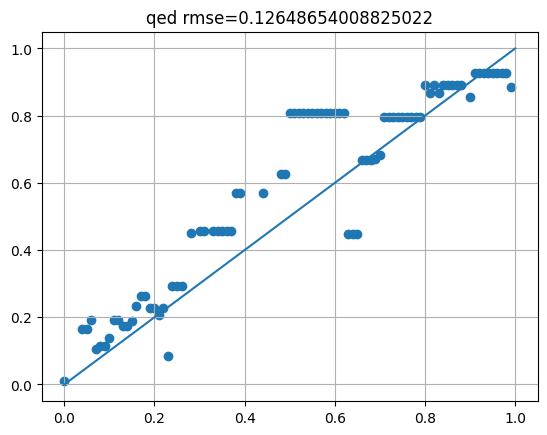

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)
plt.scatter(ground_truths, gens)
plt.plot((0,1),(0,1))
plt.title(f"qed {rmse=}")
plt.grid(True)

In [ ]:
ground_truths, gens, diffs = [],[],[]
invalids = 0
for i in np.arange(1,10, 0.1):
    prompt = f"<bos>[SAS]{i:.2f}[/SAS]"
    len_prompt = len(prompt)
    prompt = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(prompt.input_ids, do_sample=False, eos_token_id=20, max_length=300)
    out = tokenizer.batch_decode(out)[0]
    try:
        if out.find("[END_SMILES]")!=-1:
            smiles = out[out.find("[START_SMILES]") + len("[START_SMILES]"):out.find("[END_SMILES]")]
            # tpsa_score = AllChem.CalcTPSA(Chem.MolFromSmiles(smiles))
            # qed_score = QED.qed(Chem.MolFromSmiles(smiles))
            sas_score = round(sascorer.calculateScore(Chem.MolFromSmiles(smiles)), 2)
            diff = abs(i - sas_score)
            print("GT:", i, "Gen:", sas_score, "diff:", round(diff,2), smiles, out )
            ground_truths.append(i)
            gens.append(sas_score)
            diffs.append(diff)
        else:
            print(f"GT: {i} {out}")
    except:
        print(f"GT: {i} {out}")
        invalids += 1
        pass

In [ ]:
rmse = mean_squared_error(ground_truths, gens, squared=False)
print(rmse)